<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Sentence_similarity/blob/main/SB_Recomma2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers[sentencepiece]
! pip install -U sentence-transformers
!pip install gradio
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
!conda install -c pytorch faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.7 MB/s eta 0:00

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset
from datasets import load_from_disk, load_dataset

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
def check_field(examples, field):
    if examples[field] is None:
        return ""
    else:
        return (" \n " + examples[field])
    

def concatenate_text(examples):
    return {
        "sb_text": examples["titre_sb"]
        + check_field(examples, "Résumé")
        +check_field(examples, "Nature_SB")
        + check_field(examples, "origine(s)")
        + check_field(examples, "Rédacteur")
        +  check_field(examples, "Destination_SB")
        + check_field(examples, "Catégorie(s)")
        + check_field(examples, "Lieu")
        + check_field(examples, "validé/réfusé par"),

        "sjt_text": examples["titre_couv"]
        + check_field(examples, "text_lanc")
        +check_field(examples, "origine_couv")
    }

In [ ]:
sjt_sb_dataset = load_dataset("Thabet/sjt_sb", split="train")
sjt_sb_dataset = sjt_sb_dataset.map(concatenate_text)

# EDA

In [ ]:
sjt_sb_dataset.set_format("pandas")
df_train = sjt_sb_dataset[:][["id_objet_couv","id_objet_uplink", "id_objet_SB", "date_diff_y", "sjt_text", "sb_text",]]
df_train.head()

,id_objet_couv,id_objet_uplink,id_objet_SB,date_diff_y,sjt_text,sb_text
0,4521,4504,601659,2021-06-11,SJT TASSEMENT DES VACCINATIONS ? \n La vaccina...,Tassement des vaccinations ? \n News \n RN - S...
1,4533,4504,601704,2021-06-11,SJT (commun) HAUSSE PRIX ESSENCE\r\n \n Vous ...,Hausse prix essence \n News \n RN - Economie ...
2,4550,4504,601638,2021-06-11,SJT AMBIANCE EURO / SUPPORTERS \n Le retour de...,Diffusé Ouverture Euro foot \n News \n RN - En...
3,4560,4504,599619,2021-06-11,SJT EXPO ROLLING STONES À MARSEILLE \n Les Rol...,Expo Rolling Stones à Marseille DIFFUSE \n Le...
4,4755,4687,597402,2021-06-14,LA DIFFICILE COEXISTENCE ENTRE PROMENEURS ET M...,La difficile coexistence entre promeneurs et m...


In [ ]:
df_train["len_sjt"] = df_train.sjt_text.apply(lambda x: len(x))
df_train["len_sb"] = df_train.sb_text.apply(lambda x: len(x))

In [ ]:
df_train[["len_sjt","len_sb"]].describe()

,len_sjt,len_sb
count,9195.000000,9195.000000
mean,432.545514,179.381512
std,169.718999,196.143162
min,14.000000,37.000000
25%,384.000000,104.000000
50%,449.000000,124.000000
75%,505.000000,151.000000
max,6241.000000,4170.000000


Asymmetric search

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9195 entries, 0 to 9194
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_objet_couv    9195 non-null   int64         
 1   id_objet_uplink  9195 non-null   int64         
 2   id_objet_SB      9195 non-null   int64         
 3   date_diff_y      9195 non-null   datetime64[ns]
 4   sjt_text         9195 non-null   object        
 5   sb_text          9195 non-null   object        
 6   len_sjt          9195 non-null   int64         
 7   len_sb           9195 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 574.8+ KB


In [ ]:
import matplotlib.pyplot as plt

df_train["date_diff_y"] = pd.to_datetime(df_train["date_diff_y"])

def plot_curve(df):
    df_SB_PerDay=df.groupby(["date_diff_y"]).count()[["id_objet_SB"]]
    idx=df_SB_PerDay.index
    df_SB_PerDay=df_SB_PerDay.reindex(pd.date_range(idx.min(),idx.max()) , fill_value=0)
    df_SB_PerDay=df_SB_PerDay.reset_index() 
    fig,ax= plt.subplots()
    ax.plot(df_SB_PerDay['index'],df_SB_PerDay.id_objet_SB, label="Evolution NB SB par jour")
    ax.set_ylabel("NB SB créé")
    ax.legend();
    return df_SB_PerDay,ax

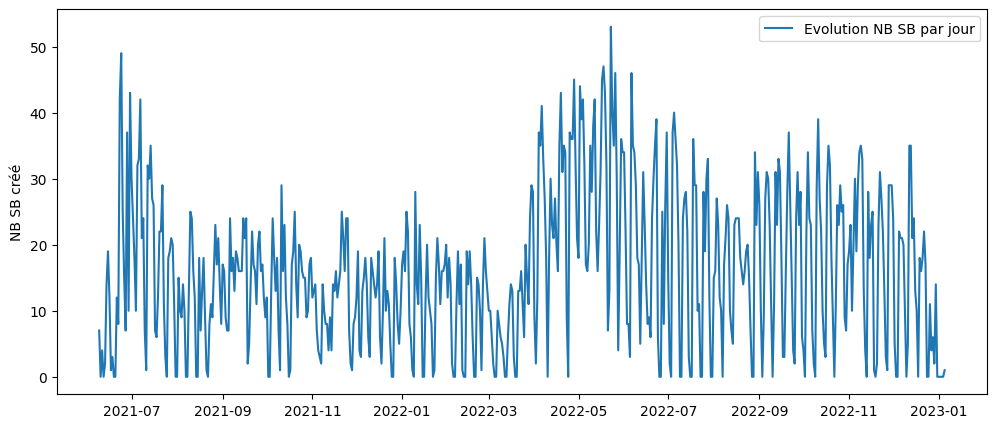

In [ ]:
 plt.rcParams['figure.figsize'] = [12, 5]
df_SB_PerDay=plot_curve(df_train)

In [ ]:
df_SB_PerDay[0]

,index,id_objet_SB
0,2021-06-09,7
1,2021-06-10,0
2,2021-06-11,4
3,2021-06-12,0
4,2021-06-13,2
...,...,...
571,2023-01-01,0
572,2023-01-02,0
573,2023-01-03,0
574,2023-01-04,0


In [ ]:
sjt_sb_dataset.reset_format()

# Dataset preparation for sentence transformers

In [ ]:
from sentence_transformers import InputExample

train_examples = []
n_examples = sjt_sb_dataset.num_rows

for i in range(n_examples):
  example = sjt_sb_dataset[i]
  train_examples.append(InputExample(texts=[example['sjt_text'], example["sb_text"]]))


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [ ]:
len(train_dataloader)

575

## Fine-tuning sentence transformers

In [ ]:
from sentence_transformers import SentenceTransformer


model_ckpt = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model = SentenceTransformer(model_ckpt)

In [ ]:
from sentence_transformers import losses

num_epochs = 10

train_loss = losses.MultipleNegativesRankingLoss(model=model)
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps) 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

In [ ]:
model.save("sb_sentence_transformer")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# model.save_to_hub(repo_name="Thabet/sb_sentence_transformer",
#                  # train_datasets=["Thabet/sjt_sb"],
#                   #private =True,
#                   )

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id="sb_sentence_transformer")

RepoUrl('https://huggingface.co/Thabet/sb_sentence_transformer', endpoint='https://huggingface.co', repo_type='model', repo_id='Thabet/sb_sentence_transformer')

In [ ]:
files_to_push_to_hub = [
    'README.md',
    'config.json',
    'config_sentence_transformers.json',
    #'merges.txt',
    'modules.json',
    'pytorch_model.bin',
    'sentence_bert_config.json',
    "sentencepiece.bpe.model",
    'special_tokens_map.json',
    'tokenizer.json',
    'tokenizer_config.json',
    #'vocab.json'
]

for filename in files_to_push_to_hub:
  api.upload_file(
      path_or_fileobj="/content/sb_sentence_transformer/"+filename,
      repo_id="Thabet/sb_sentence_transformer",
      path_in_repo=filename,
      repo_type="model",
      # commit_message="Pushing simcse 500k model",
      # commit_description="Model trained on 500k tweets using simcse unsup"
  )

api.upload_folder(
    folder_path="/content/sb_sentence_transformer/1_Pooling",
    path_in_repo="1_Pooling",
    repo_id="Thabet/sb_sentence_transformer",
    repo_type="model",
)


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

'https://huggingface.co/Thabet/sb_sentence_transformer/tree/main/1_Pooling'

## Evaluation

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_ckpt = "Thabet/sb_sentence_transformer"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
device = torch.device("cpu")
model.to(device)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

### Loading validation dataset

In [ ]:
# from datasets import load_from_disk, load_dataset
# sb_dataset = load_from_disk("sjt_sb_val")
# sb_dataset.push_to_hub("sjt_sb_val")
val_dataset = load_dataset("Thabet/sjt_sb_val", split="train")
val_dataset = val_dataset.map(concatenate_text)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1416 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Thabet___parquet/Thabet--sjt_sb_val-4a6e6addd541a928/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Map:   0%|          | 0/1416 [00:00<?, ? examples/s]

### Creation of Embeddings from sb

In [ ]:
# from datasets import load_from_disk, load_dataset
# sb_dataset = load_from_disk("sb_dataset")
# sb_dataset.push_to_hub("sb_dataset2")
sb_dataset = load_dataset("Thabet/sb_dataset2", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/119520 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Thabet___parquet/Thabet--sb_dataset2-932f7e237929d61f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
# embeddings_dataset = sb_dataset.map(
#     lambda x: {"embeddings": get_embeddings(x["text"]).detach().cpu().numpy()[0]}
# )

# embeddings_dataset.push_to_hub("embeddings_dataset")

embeddings_dataset = load_dataset("Thabet/embeddings_dataset", split="train")
embeddings_dataset.add_faiss_index(column="embeddings")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/119520 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Thabet___parquet/Thabet--embeddings_dataset-17762ce5c75be3cd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/120 [00:00<?, ?it/s]

Dataset({
    features: ['titre_sb', 'id_objet_SB', 'id_objet_container', 'Nature_SB', 'Résumé', 'Lieu', 'origine(s)', 'Rédacteur', 'validé/réfusé le', 'Destination_SB', 'Catégorie(s)', 'date_creation', 'date_début', 'date_fin', 'validé/réfusé par', '__index_level_0__', 'text', 'embeddings'],
    num_rows: 119520
})

### Evaluation

In [ ]:
from tqdm.auto import tqdm

sb_gt=[]
sb_pred=[]
for i in tqdm(range(len(val_dataset)), total = len(val_dataset)):
  ex_couv = val_dataset["sjt_text"][i]
  #sb_title, sb_resume, sb_date, sb_id = sb_target(i)
  sb_gt.append(val_dataset["id_objet_SB"][i])
  couv_embedding = get_embeddings([ex_couv]).cpu().detach().numpy()
  scores, samples = embeddings_dataset.get_nearest_examples( "embeddings", couv_embedding, k=10)
  sb_pred.append(samples["id_objet_SB"])


  0%|          | 0/1416 [00:00<?, ?it/s]

In [ ]:
TP=0
for i in tqdm(range(len(val_dataset)), total = len(val_dataset)):
  for sb in sb_pred[i]:
    if sb == sb_gt[i]:
      TP+=1

(TP/len(sb_pred))*100

  0%|          | 0/1416 [00:00<?, ?it/s]

74.29378531073446

array([[<Axes: title={'center': 'diff'}>]], dtype=object)

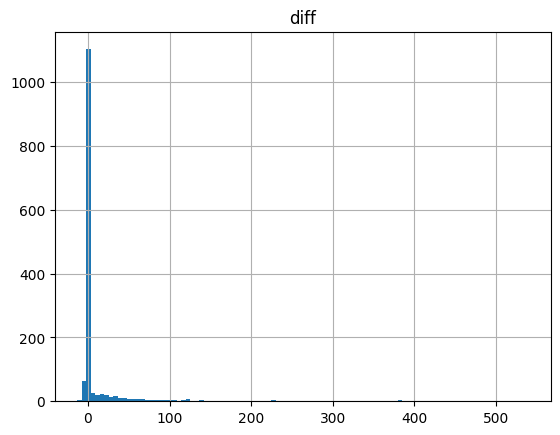

In [ ]:
val_dataset.set_format("pandas")
df=val_dataset[:]
df["date_creation"] = pd.to_datetime(df["date_creation"])
df["date_creation_sb"] = pd.to_datetime(df["date_creation_sb"])
df["diff"]=df["date_creation"] - df["date_creation_sb"]
df["diff"]=df["diff"].dt.days
df.hist(column="diff", bins=100)

In [ ]:
from tqdm.auto import tqdm

sb_gt=[]
sb_pred=[]
for i in tqdm(range(len(df)), total = len(df)):
  ex_couv = df["sjt_text"][i]
  date_couv = df["date_creation"][i]
  #sb_title, sb_resume, sb_date, sb_id = sb_target(i)
  sb_gt.append(df["id_objet_SB"][i])
  couv_embedding = get_embeddings([ex_couv]).cpu().detach().numpy()
  scores, samples = embeddings_dataset.get_nearest_examples( "embeddings", couv_embedding, k=10)
  preds=[]
  for j, date in enumerate(samples["date_creation"]):
    date_sb  = datetime.strptime(date, "%Y-%m-%d")
    diff = (date_couv - date_sb).days
    if (diff >-30) & (diff<30):
      preds.append(samples["id_objet_SB"][j])
  sb_pred.append(preds)

  0%|          | 0/1416 [00:00<?, ?it/s]

In [ ]:
TP=0
for i in tqdm(range(len(val_dataset)), total = len(val_dataset)):
  if len(sb_pred[i])!=0:
    for sb in sb_pred[i]:
      if sb == sb_gt[i]:
        TP+=1

(TP/len(sb_pred))*100 

  0%|          | 0/1416 [00:00<?, ?it/s]

66.17231638418079

In [ ]:
val_dataset.reset_format()

#Prediction

In [ ]:
def predict (titre_couv, text_lanc, origine_couve =None, n_samples=5,):
  ex_couv = titre_couv + str(text_lanc) + str(origine_couve)
  couv_embedding = get_embeddings([ex_couv]).cpu().detach().numpy()
  scores, samples = embeddings_dataset.get_nearest_examples( "embeddings", couv_embedding, k=n_samples)
  samples_df = pd.DataFrame.from_dict({"titre_sb":samples["titre_sb"], "date de création" : samples['date_creation']})
  #samples_df["date de création"] = pd.to_datetime(samples_df["date de création"])
  samples_df["scores"] = scores
  return samples_df


In [ ]:
from datetime import datetime, timedelta

def predict_with_date (titre_couv, text_lanc, origine_couve =None, date_creation="", n_samples=5,):# profondeur_de_recherche=15):
  ex_couv = titre_couv + str(text_lanc) + str(origine_couve)
  couv_embedding = get_embeddings([ex_couv]).cpu().detach().numpy()
  scores, samples = embeddings_dataset.get_nearest_examples( "embeddings", couv_embedding, k=n_samples)
  samples_df = pd.DataFrame.from_dict({"titre_sb":samples["titre_sb"], "date de création" : samples['date_creation']})
  #samples_df["date de création"] = pd.to_datetime(samples_df["date de création"])
  samples_df["scores"] = scores
  if len(date_creation)!=0:
    samples_df["date de création"] = pd.to_datetime(samples_df["date de création"])
    samples_df=samples_df.loc[(samples_df["date de création"]>=datetime.strptime(date_creation, "%Y-%m-%d")-timedelta(days=15)) & 
                              (samples_df["date de création"]<=datetime.strptime(date_creation, "%Y-%m-%d")+timedelta(days=5))]
  return samples_df

# Making a demo with Gradio

In [ ]:
title = "Recherche et recommandation des Story bins"
description = """Ceci est une démo de recherche sémantique et recommandation des story bins pour des couvretures similaires, en utilisant des algo d'IA et des techniques de NLP.
Les données SB de recherche utilisées pour la démo s'étalent jusqu'à 25/03/2023"""
#examples = []


In [ ]:
text_lanc= """Un plan d'urgence pour réduire les délais pour refaire vos papiers d'identité... Actuellement, il faut compter en moyenne, 65 jours... 
Le gouvernement s'engage à diminuer le délai...
A l'approche de l'été, vous êtes toujours très nombreux à galérer pour obtenir un rendez-vous...
Dans certaines régions les petites communes prennent le relais pour soulager les services des préfectures saturés...
Illustration à SAINT CHINIAN dans l'HéRAULT avec Diane SCHLINGER et nos équipes en région

((SUJET))"""

In [ ]:
from typing import Optional
import gradio as gr

gr.Interface(
    fn=predict_with_date,
    inputs=[
            gr.Textbox(label="Titre couverture", placeholder="En majuscule"),
            gr.Textbox(label="Text lancement", placeholder="En miniscule",optional= True),
            gr.Textbox(label="Origine couverture", optional= True),
            gr.Textbox(label="date de création", placeholder="YYYY-mm-dd", optional= True),
            gr.Slider(1, 10, step=1),
            ],
    outputs=gr.Dataframe(headers=["titre_sb", "date de création", "scores"],overflow_row_behaviour="show_ends"),
    title=title,
    description=description,
    #article=article,
    examples=[
              ["CABINE !! DELAI CARTE D'IDENTITE NATIONALE", None, None, ""],
              ["CABINE !! DELAI CARTE D'IDENTITE NATIONALE", text_lanc, None, ""],
              [val_dataset[0]["titre_couv"], val_dataset[0]["text_lanc"], val_dataset[0]["origine_couv"], ""],
              [val_dataset[0]["titre_couv"], val_dataset[0]["text_lanc"], val_dataset[0]["origine_couv"], str(val_dataset[0]["date_creation"]).split(" ")[0]],
              [val_dataset[1000]["titre_couv"], val_dataset[1000]["text_lanc"], val_dataset[1000]["origine_couv"], str(val_dataset[1000]["date_creation"]).split(" ")[0]], #bad recomma
              [val_dataset[1220]["titre_couv"], None,val_dataset[1220]["origine_couv"],str(val_dataset[1220]["date_creation"]).split(" ")[0]], #bad recomman
              [val_dataset[1300]["titre_couv"], val_dataset[1300]["text_lanc"], val_dataset[1300]["origine_couv"],str(val_dataset[1300]["date_creation"]).split(" ")[0]],
              ],
).launch(share=True)

/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2bd8860af1e49a3e07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


#Adding SB data to the index